# Import Library: 분석에 사용할 모듈 설치
**1. Import Library**

In [1]:
!python -m pip install --user --upgrade pip
!pip install xgboost --user --upgrade
!pip install lightgbm --user --upgrade

distutils: C:\Users\KK\AppData\Roaming\Python\Python38\Include\UNKNOWN
sysconfig: C:\Users\KK\AppData\Roaming\Python\Python38\Include
user = True
home = None
root = None
prefix = None


distutils: C:\Users\KK\AppData\Roaming\Python\Python38\Include\UNKNOWN
sysconfig: C:\Users\KK\AppData\Roaming\Python\Python38\Include
user = True
home = None
root = None
prefix = None


distutils: C:\Users\KK\AppData\Roaming\Python\Python38\Include\UNKNOWN
sysconfig: C:\Users\KK\AppData\Roaming\Python\Python38\Include
user = True
home = None
root = None
prefix = None


In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Modeling algorithms
# General
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn import metrics

In [3]:
### Preprocessing
def fillnull(df):
    # 결측값 처리
    ## Age
    df_agem = df[df.Sex == 'male']
    df_agem = df_agem[['Age']].fillna(df_agem[['Age']].mean())

    df_agefm = df[df.Sex == 'female']
    df_agefm = df_agefm[['Age']].fillna(df_agefm[['Age']].mean())
    df[['Age']] = pd.concat([df_agem, df_agefm], axis=0).sort_index()

    ## Embarked
    df[['Embarked']] = df[['Embarked']].fillna(df['Embarked'].mode()[0], axis=0)

    ## Cabin
    df['Cabin'] = df['Cabin'].str.slice(0,1)
    df['Cabin'] = df['Cabin'].fillna('Temp')
    
    return df


def prep(df):
    # Name
    name_sub = df['Name'].str.split(',', expand=True)[1]
    name_sub = name_sub.str.split('. ', expand=True)[0]
    name_sub.replace([' Mr'], 'Mr', inplace=True)
    name_sub.replace([' Mrs'], 'Mrs', inplace=True)
    name_sub.replace([' Ms', ' Miss'], 'Miss', inplace=True)
    name_sub.replace([' Don', ' Mme', ' Lady', 'Sir', 'Mlle', ' th', ' Jonkheer'], 'Noble', inplace=True)
    name_sub.replace([' Master', ' Major', ' Col', ' Capt', ' Sir', ' Mlle', ' Jonkheer'], 'Officer', inplace=True)
    name_sub.replace([' Dr', ' Rev'], 'Priest', inplace=True)
    df['Name'] = name_sub.copy()

    # Ticket
    df['Ticket'] = df['Ticket'].str.replace('.','').str.replace('/','')
    df['Ticket'] = df['Ticket'].str.strip().str.split(' ').str[0]
    df.loc[df['Ticket'].str.isdigit(), 'Ticket'] = 'NUM'

    # Age
    age_interval = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    if df['Age'].max() > len(age_interval):
        df['Age'] = np.digitize(df['Age'], bins=age_interval)
        
    return df


def datasplit(df, Y_colname, test_size=0.2, random_state=123):
    X_colname = [x for x in df.columns if x not in Y_colname]
       
    X_train, X_test, Y_train, Y_test = train_test_split(df[X_colname], df[Y_colname],
                                                        test_size=test_size, random_state=random_state)
    print(X_train.shape, Y_train.shape)
    print(X_test.shape, Y_test.shape)
    
    return X_train, X_test, Y_train, Y_test


def label_encoding(X_train, X_test, colname, encoder):
    X_train_le = X_train.copy()
    X_test_le = X_test.copy()
    
    for i in colname: # 대상 변수들마다
        encoder = encoder.fit(X_train[i])

        for label in X_test[i].unique():
            if label not in encoder.classes_:
                encoder.classes_ = np.append(encoder.classes_, label)

        X_train_le[i] = encoder.transform(X_train[i])
        X_test_le[i] = encoder.transform(X_test[i])
        
    return X_train_le, X_test_le


def onehot_encoding(df, colname):
    df_ohe = df.copy()
    
    for i in colname:
        if i in df.columns:
            df_ohe = pd.get_dummies(df_ohe, columns=[i], drop_first=True)
            
    return df_ohe


def col_mapping(X_train, X_test):
    X_tr = X_train.copy()
    X_te = X_test.copy()
    
    # checking the difference of columns
    X_te_noncol = [i for i in X_tr.columns if i not in X_te.columns]
    X_tr_noncol = [i for i in X_te.columns if i not in X_tr.columns]

    # duplicates
    if X_te_noncol != []:
        for i in X_te_noncol:
            X_te[i] = 0
            X_te = X_te[X_tr.columns].copy()
            
    if X_tr_noncol != []:
        for i in X_tr_noncol:
            X_tr[i] = 0
            X_tr = X_tr[X_te.columns].copy()
            
    return X_tr, X_te


def scale(scaler, X_train, X_test):
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                                   index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                                  index=X_test.index, columns=X_test.columns)
    
    return X_train_scaling, X_test_scaling


### Evaluation
# Confusion Matrix
def evaluation_class_ConfusionMatrix(Y_true, Y_pred):
    conf_mat = metrics.confusion_matrix(Y_true, Y_pred)
    conf_mat = pd.DataFrame(conf_mat, 
                            index=['True: 0', 'True: 1'], 
                            columns=['Pred: 0', 'Pred: 1'])
    
    return conf_mat


# Classification Metrics
def evaluation_class_ClassificationReport(Y_true, Y_pred):
    print(metrics.classification_report(Y_true, Y_pred, 
                                        target_names=['class 0', 'class 1']))
    

# ROC Curve + AUC
def evaluation_class_ROCAUC(Y_true, P_pred, figsize=(10,5)):
    fpr, tpr, thresholds = metrics.roc_curve(Y_true, P_pred)
    cm = evaluation_class_ConfusionMatrix(Y_true, P_pred>=0.5)
    recall = cm.iloc[1,1] / cm.sum(axis=1).values[1]
    fallout = cm.iloc[0,1] / cm.sum(axis=1).values[0]
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot([fallout], [recall], 'ro', ms=10)
    plt.title('AUC: ' + str(metrics.auc(fpr, tpr)), fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.show()
    
    
# Precision-Recall Curve
def evaluation_class_PrecisionRecall(Y_true, P_pred, figsize=(10,5)):
    pre, rec, thresholds = metrics.precision_recall_curve(Y_true, P_pred)
    
    plt.figure(figsize=figsize)
    plt.plot(thresholds, pre[:-1], label='Precision')
    plt.plot(thresholds, rec[1:], label='Recall')
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.show()

# Base Algorithm: Logistic Regression

(712, 11) (712, 1)
(179, 11) (179, 1)
Optimization terminated successfully.
         Current function value: 0.414285
         Iterations 17
Effect of X..


,features,coef,odds
0,const,2.00,7.39
1,Pclass,-1.44,0.24
2,Age,-3.08,0.05
3,SibSp,-0.97,0.38
4,Parch,0.01,1.01
5,Fare,0.75,2.12
6,Cabin,-0.54,0.58
7,Name_Mrs,2.14,8.50
8,Embarked_S,-0.53,0.59


Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.76      0.89      0.82       435
     class 1       0.76      0.56      0.64       277

    accuracy                           0.76       712
   macro avg       0.76      0.72      0.73       712
weighted avg       0.76      0.76      0.75       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.82      0.87      0.85       114
     class 1       0.75      0.68      0.71        65

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179

ROC Curve: Train


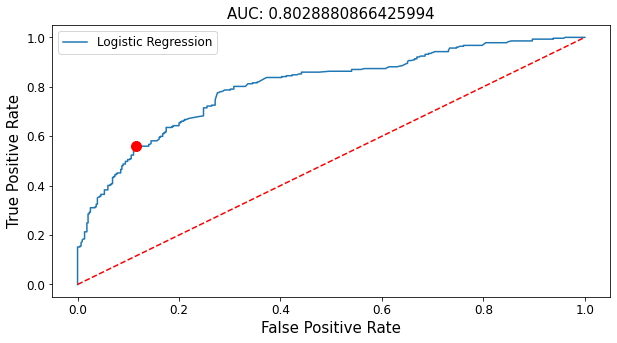

ROC Curve: Test


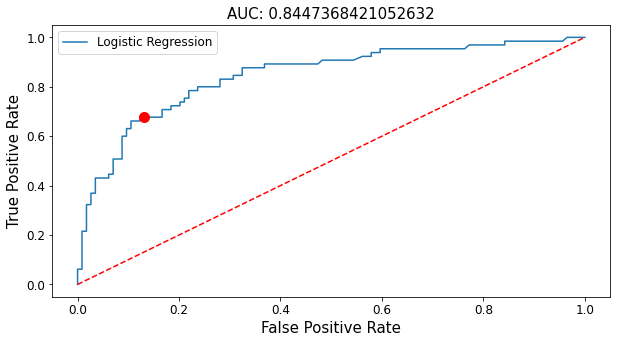

Precision-Recall Curve: Train


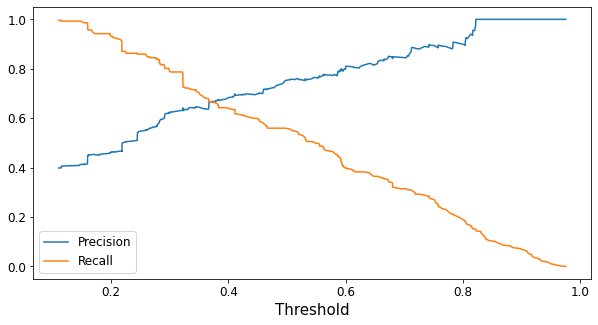

Precision-Recall Curve: Test


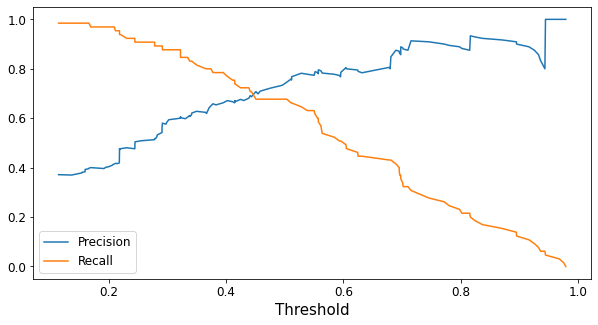

In [4]:
# Data Loading
location = r'.\Data\Titanic\Titanic.csv'
df = pd.read_csv(location)

# Preprocessing
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

# 로지스틱 적용 (statsmodels)
X_train_fes = sm.add_constant(X_train_fes)
X_test_fes = sm.add_constant(X_test_fes)
algo_logitreg = sm.Logit(Y_train, X_train_fes).fit()
## 유의한 변수 선택
pval_criteria = 0.5
good = algo_logitreg.pvalues <= pval_criteria
X_colname_good = list(good.index[good == True])
## 로지스틱 재적용 (sklearn)
X_train_fes = X_train_fes[X_colname_good].copy()
X_test_fes = X_test_fes[X_colname_good].copy()

algo_logitreg = LogisticRegression(fit_intercept=False)
algo_logitreg.fit(X_train_fes, Y_train)

## 계수 해석
print("Effect of X..")
display(pd.DataFrame({'features': X_train_fes.columns,
                      'coef': algo_logitreg.coef_[0],
                      'odds': np.exp(algo_logitreg.coef_[0])}))

# 예측
Y_trpred = algo_logitreg.predict(X_train_fes)
Y_tepred = algo_logitreg.predict(X_test_fes)
P_trpred = algo_logitreg.predict_proba(X_train_fes)
P_tepred = algo_logitreg.predict_proba(X_test_fes)

## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred[:,1])

# Advanced Algorithm: Bagging

## Decision Tree

(712, 11) (712, 1)
(179, 11) (179, 1)
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       435
     class 1       1.00      1.00      1.00       277

    accuracy                           1.00       712
   macro avg       1.00      1.00      1.00       712
weighted avg       1.00      1.00      1.00       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.82      0.75      0.78       114
     class 1       0.61      0.71      0.66        65

    accuracy                           0.73       179
   macro avg       0.72      0.73      0.72       179
weighted avg       0.74      0.73      0.74       179

ROC Curve: Train


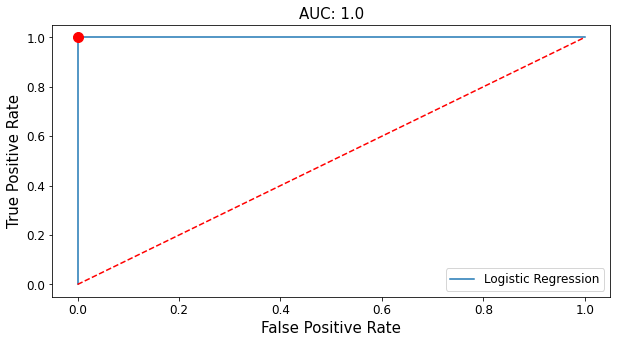

ROC Curve: Test


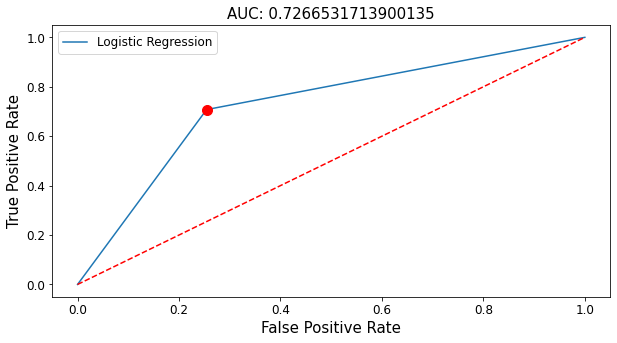

Precision-Recall Curve: Train


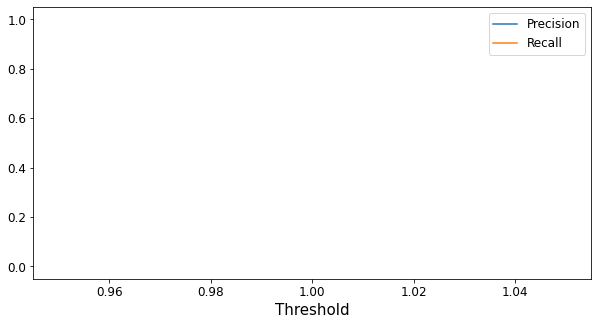

Precision-Recall Curve: Test


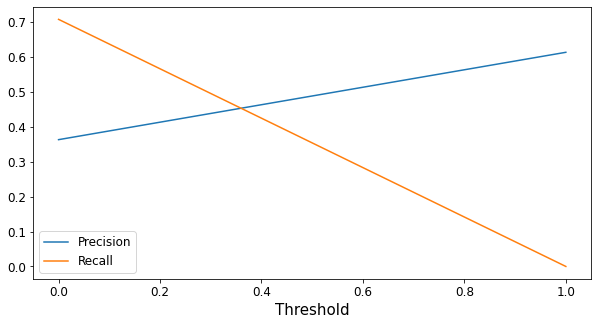

In [5]:
# Data Loading
location = r'.\Data\Titanic\Titanic.csv'
df = pd.read_csv(location)

# Preprocessing
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Bagging
# DecisionTree
algo_dt = DecisionTreeClassifier(criterion='gini').fit(X_train_fes, Y_train)
Y_trpred_dt = algo_dt.predict(X_train_fes).flatten()
Y_tepred_dt = algo_dt.predict(X_test_fes).flatten()
P_trpred_dt = algo_dt.predict_proba(X_train_fes)
P_tepred_dt = algo_dt.predict_proba(X_test_fes)

## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred_dt)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred_dt)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred_dt)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred_dt)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred_dt[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred_dt[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred_dt[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred_dt[:,1])

## Random Forest

(712, 11) (712, 1)
(179, 11) (179, 1)
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       435
     class 1       1.00      1.00      1.00       277

    accuracy                           1.00       712
   macro avg       1.00      1.00      1.00       712
weighted avg       1.00      1.00      1.00       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.87      0.86      0.86       114
     class 1       0.76      0.77      0.76        65

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179

ROC Curve: Train


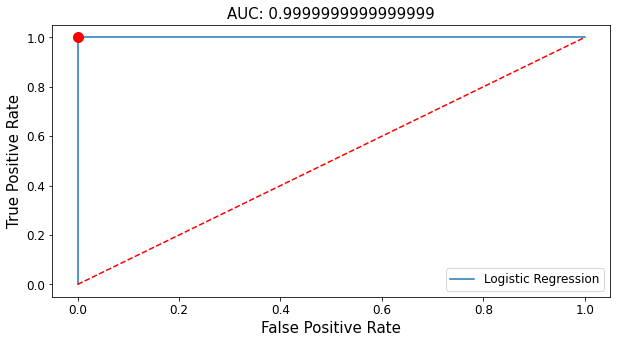

ROC Curve: Test


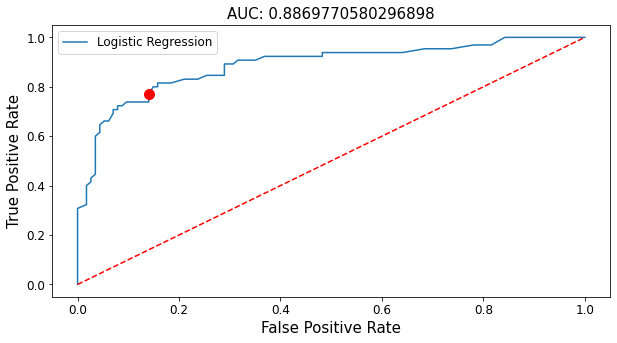

Precision-Recall Curve: Train


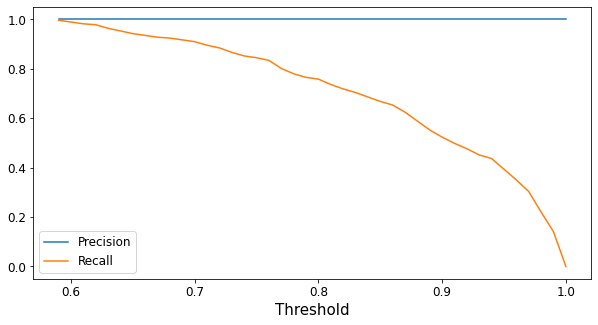

Precision-Recall Curve: Test


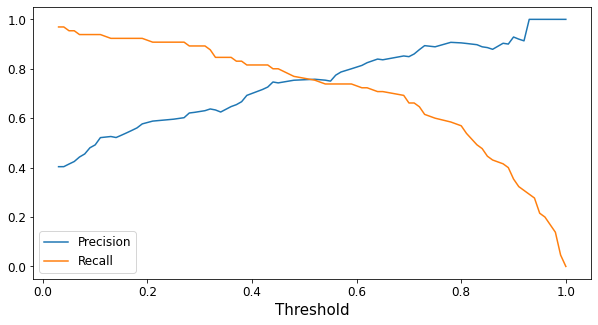

In [6]:
# Data Loading
location = r'.\Data\Titanic\Titanic.csv'
df = pd.read_csv(location)

# Preprocessing
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Bagging
# RandomForestClassifier
algo_rf = RandomForestClassifier(criterion='gini',
                                 n_estimators=100, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_rf = algo_rf.predict(X_train_fes).flatten()
Y_tepred_rf = algo_rf.predict(X_test_fes).flatten()
P_trpred_rf = algo_rf.predict_proba(X_train_fes)
P_tepred_rf = algo_rf.predict_proba(X_test_fes)

## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred_rf)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred_rf)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred_rf)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred_rf)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred_rf[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred_rf[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred_rf[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred_rf[:,1])

# Advanced Algorithm: Boosting

## Gradient Boosting

(712, 11) (712, 1)
(179, 11) (179, 1)
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.88      0.92      0.90       435
     class 1       0.87      0.79      0.83       277

    accuracy                           0.87       712
   macro avg       0.87      0.86      0.86       712
weighted avg       0.87      0.87      0.87       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.87      0.89      0.88       114
     class 1       0.79      0.77      0.78        65

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC Curve: Train


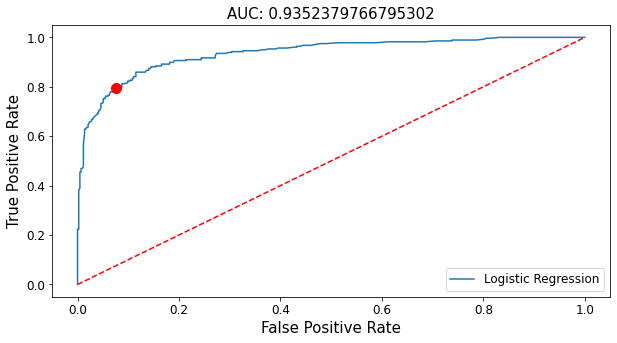

ROC Curve: Test


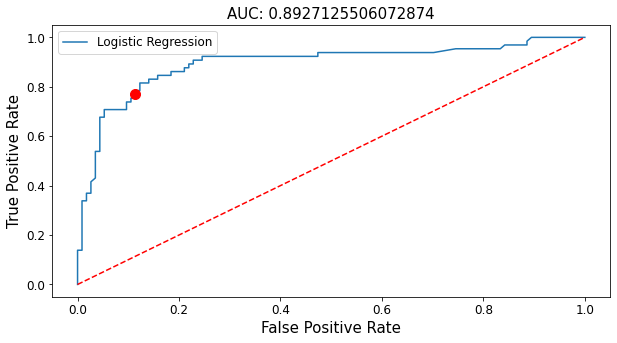

Precision-Recall Curve: Train


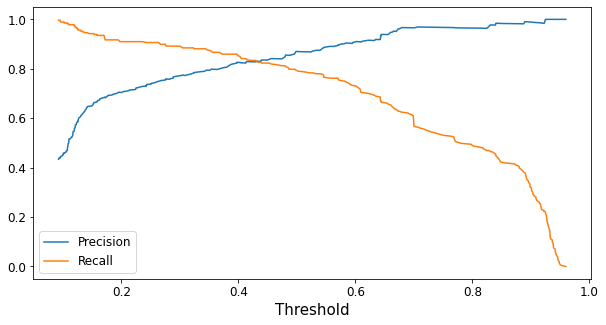

Precision-Recall Curve: Test


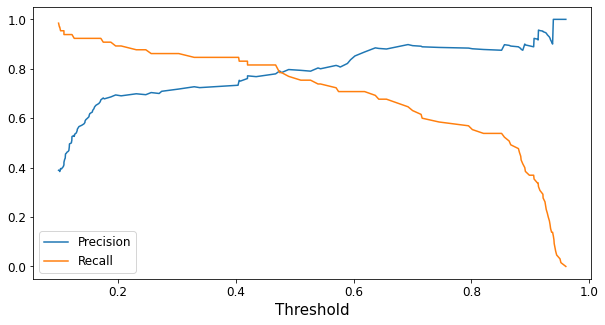

In [7]:
# Data Loading
location = r'.\Data\Titanic\Titanic.csv'
df = pd.read_csv(location)

# Preprocessing
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Boosting
# GradientBoostingClassifier
algo_gb = GradientBoostingClassifier(learning_rate=0.05, 
                                     loss='deviance', criterion='friedman_mse',
                                     n_estimators=100, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_gb = algo_gb.predict(X_train_fes).flatten()
Y_tepred_gb = algo_gb.predict(X_test_fes).flatten()
P_trpred_gb = algo_gb.predict_proba(X_train_fes)
P_tepred_gb = algo_gb.predict_proba(X_test_fes)

## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred_gb)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred_gb)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred_gb)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred_gb)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred_gb[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred_gb[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred_gb[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred_gb[:,1])

## XGBoost

(712, 11) (712, 1)
(179, 11) (179, 1)
[17:11:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.92      0.98      0.95       435
     class 1       0.96      0.86      0.91       277

    accuracy                           0.93       712
   macro avg       0.94      0.92      0.93       712
weighted avg       0.93      0.93      0.93       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.86      0.87       114
     class 1       0.76      0.78      0.77        65

    accuracy                           0.83       179
 

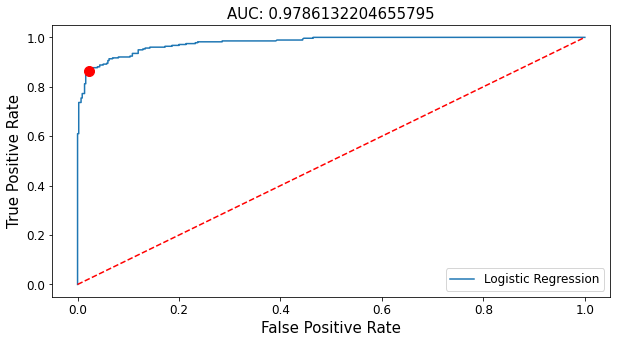

ROC Curve: Test


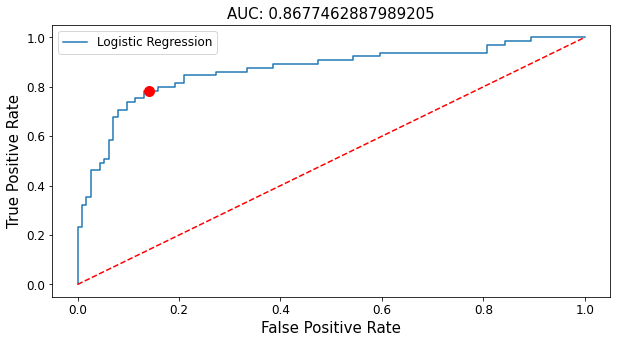

Precision-Recall Curve: Train


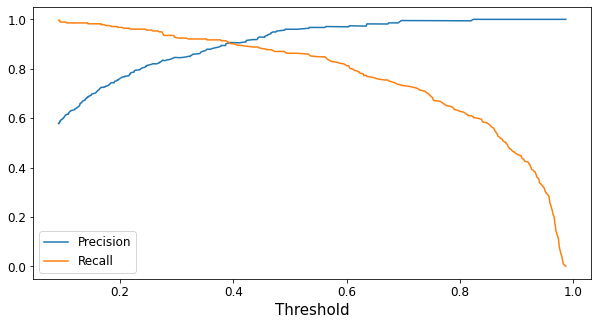

Precision-Recall Curve: Test


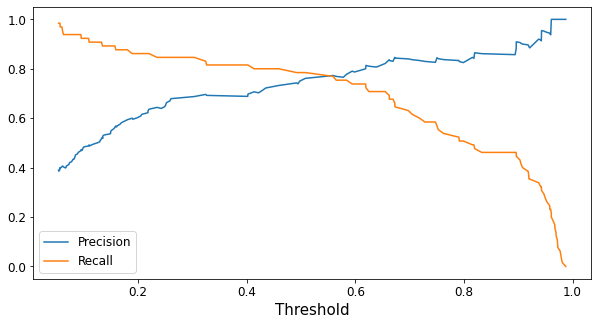

In [8]:
# Data Loading
location = r'.\Data\Titanic\Titanic.csv'
df = pd.read_csv(location)

# Preprocessing
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Boosting
# XGBClassifier
algo_xgb = XGBClassifier(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_xgb = algo_xgb.predict(X_train_fes).flatten()
Y_tepred_xgb = algo_xgb.predict(X_test_fes).flatten()
P_trpred_xgb = algo_xgb.predict_proba(X_train_fes)
P_tepred_xgb = algo_xgb.predict_proba(X_test_fes)

## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred_xgb)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred_xgb)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred_xgb)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred_xgb)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred_xgb[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred_xgb[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred_xgb[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred_xgb[:,1])

## LightGBM

(712, 11) (712, 1)
(179, 11) (179, 1)
Confusion Matrix: Train
Confusion Matrix: Test
Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.92      0.96      0.94       435
     class 1       0.94      0.87      0.90       277

    accuracy                           0.93       712
   macro avg       0.93      0.92      0.92       712
weighted avg       0.93      0.93      0.93       712

Classification Metrics: Test
              precision    recall  f1-score   support

     class 0       0.88      0.86      0.87       114
     class 1       0.76      0.78      0.77        65

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

ROC Curve: Train


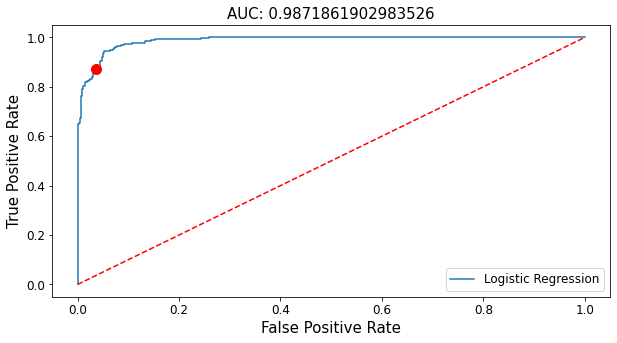

ROC Curve: Test


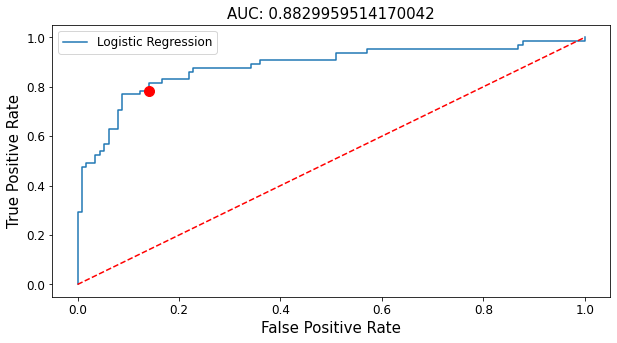

Precision-Recall Curve: Train


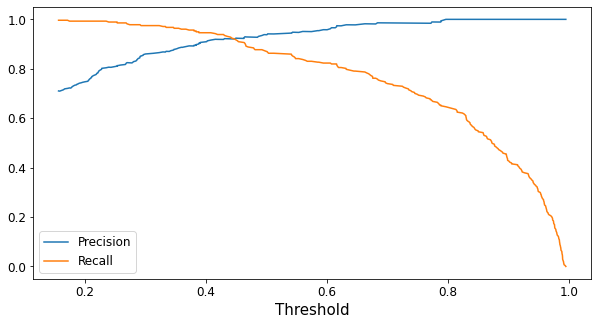

Precision-Recall Curve: Test


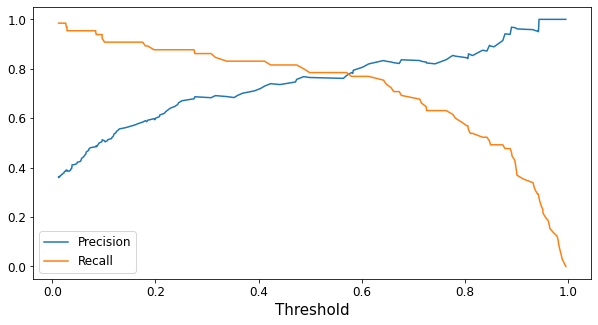

In [9]:
# Data Loading
location = r'.\Data\Titanic\Titanic.csv'
df = pd.read_csv(location)

# Preprocessing
df = fillnull(df)
df = prep(df)

Y_colname = ['Survived']
X_train, X_test, Y_train, Y_test = datasplit(df, Y_colname)

label_colname = ['Sex', 'Cabin', 'Ticket']
encoder = preprocessing.LabelEncoder()
X_train_fe, X_test_fe = label_encoding(X_train, X_test, label_colname, encoder)

onehot_colname = ['Name', 'Embarked']
X_train_fe = onehot_encoding(X_train_fe, onehot_colname)
X_test_fe = onehot_encoding(X_test_fe, onehot_colname)
X_train_fe, X_test_fe = col_mapping(X_train_fe, X_test_fe)   

scaler = preprocessing.MinMaxScaler()
X_train_fes, X_test_fes = scale(scaler, X_train_fe, X_test_fe)

### Boosting
# LightGMB
algo_lgbm = LGBMClassifier(learning_rate=0.05, n_estimators=100, random_state=123).fit(X_train_fes, Y_train)
Y_trpred_lgbm = algo_lgbm.predict(X_train_fes).flatten()
Y_tepred_lgbm = algo_lgbm.predict(X_test_fes).flatten()
P_trpred_lgbm = algo_lgbm.predict_proba(X_train_fes)
P_tepred_lgbm = algo_lgbm.predict_proba(X_test_fes)

## Confusion Matrix
print('Confusion Matrix: Train')
evaluation_class_ConfusionMatrix(Y_train, Y_trpred_lgbm)
print('Confusion Matrix: Test')
evaluation_class_ConfusionMatrix(Y_test, Y_tepred_lgbm)

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(Y_train, Y_trpred_lgbm)
print('Classification Metrics: Test')
evaluation_class_ClassificationReport(Y_test, Y_tepred_lgbm)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(Y_train, P_trpred_lgbm[:,1])
print('ROC Curve: Test')
evaluation_class_ROCAUC(Y_test, P_tepred_lgbm[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(Y_train, P_trpred_lgbm[:,1])
print('Precision-Recall Curve: Test')
evaluation_class_PrecisionRecall(Y_test, P_tepred_lgbm[:,1])

# Comparison: Top Algorithm

ROC Curve: Logistic


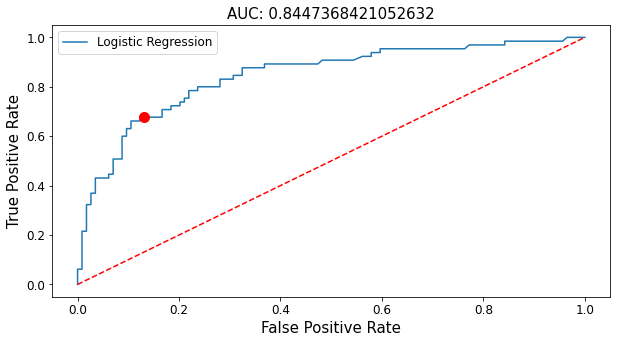

ROC Curve: Decision Tree


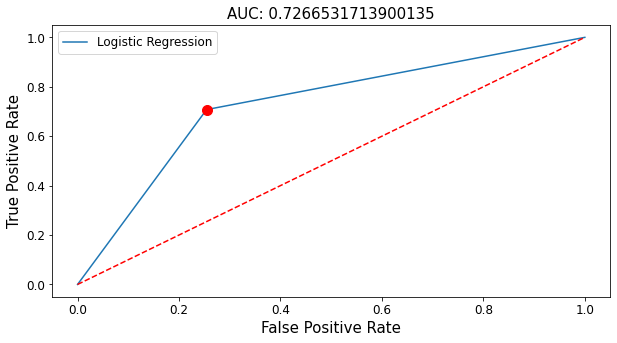

ROC Curve: Random Forest


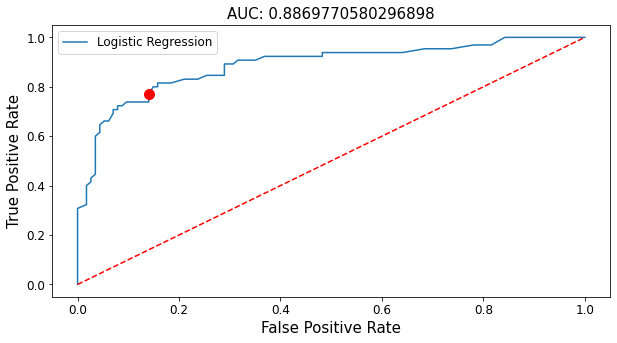

ROC Curve: Gradient Boosting


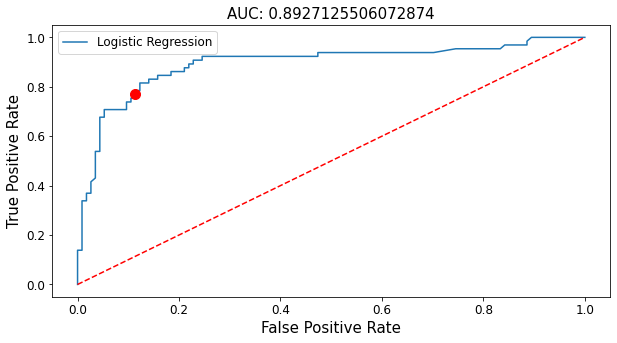

ROC Curve: XGBoost


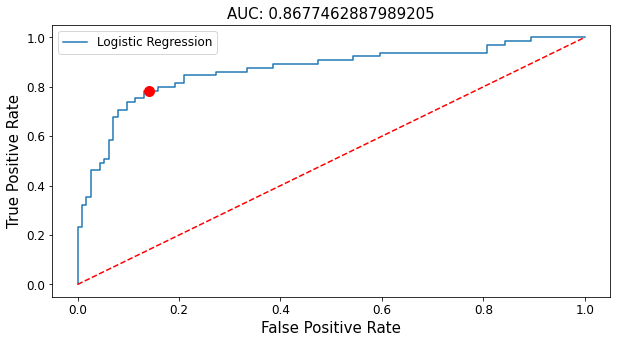

ROC Curve: LightGBM


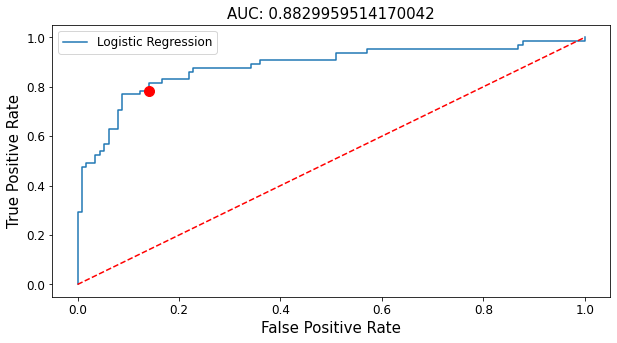

In [11]:
print('ROC Curve: Logistic')
evaluation_class_ROCAUC(Y_test, P_tepred[:,1])
print('ROC Curve: Decision Tree')
evaluation_class_ROCAUC(Y_test, P_tepred_dt[:,1])
print('ROC Curve: Random Forest')
evaluation_class_ROCAUC(Y_test, P_tepred_rf[:,1])
print('ROC Curve: Gradient Boosting')
evaluation_class_ROCAUC(Y_test, P_tepred_gb[:,1])
print('ROC Curve: XGBoost')
evaluation_class_ROCAUC(Y_test, P_tepred_xgb[:,1])
print('ROC Curve: LightGBM')
evaluation_class_ROCAUC(Y_test, P_tepred_lgbm[:,1])